In [4]:
# examinations of the all-sky error table for AMSUA/ATMS
# initial built: ?
# modified: (modified from nonGaussian_omf_analysis.ipynb) at 2024/10/09
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [7]:
instrument = 'amsua'
channel    = 'ch1'

In [8]:
fn = f'/scratch4/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/default_used_to_build_pdfs/omf_stats_{instrument}_{channel}.csv'
df = pd.read_csv(fn)

In [9]:
df.info()
#df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18327123 entries, 0 to 18327122
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   sensor      object 
 1   lat         float64
 2   lon         float64
 3   channel     int64  
 4   scana       float64
 5   qcmark      float64
 6   fwater      float64
 7   fland       float64
 8   omf_ges     float64
 9   errinv_ges  float64
 10  symerr_ges  float64
 11  clw_obs     float64
 12  clw_bg_ges  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.8+ GB


In [10]:
# screen the data:
dfs = df[abs(df['omf_ges']) < 1e3]

In [11]:
# sort the data based on regions

#regions=['land','sea']
#lats   =['Global','90S-60S','60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N','60N-90N']

regions = ['sea']
lats    = ['Global']

adf={} # "a"nalysis "d"ata "f"rame

for rg in regions:
    adf[rg] = {}  # Initialize the nested dictionary for each experiment
    if rg == 'land':
        dftmp = dfs.loc[ dfs['fland']>=0.99 ]
    elif rg == 'sea':
        dftmp = dfs.loc[ dfs['fwater']>=0.99 ]
        
    for lat in lats:
        if lat == 'Global':
            adf[rg][lat] = dftmp
        elif lat == '90S-60S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-60) & (dftmp['lat']>-90) ]
        elif lat == '60S-40S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-40) & (dftmp['lat']>-60) ]
        elif lat == '40S-20S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-20) & (dftmp['lat']>-40) ]
        elif lat == '20S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=0) & (dftmp['lat']>-20) ]
        elif lat == '0-20N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=20) & (dftmp['lat']>0) ]
        elif lat == '20N-40N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=40) & (dftmp['lat']>20) ]
        elif lat == '40N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=60) & (dftmp['lat']>40) ]
        elif lat == '60N-90N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=90) & (dftmp['lat']>60) ]

In [12]:
adf['sea']['Global'].describe()

,lat,lon,channel,scana,qcmark,fwater,fland,omf_ges,errinv_ges,symerr_ges,clw_obs,clw_bg_ges
count,1.630522e+07,1.630522e+07,16305221.0,1.630522e+07,1.630522e+07,1.630522e+07,1.630522e+07,1.630522e+07,1.630522e+07,1.630522e+07,1.630522e+07,1.630522e+07
mean,-3.592695e+00,1.947140e+02,1.0,1.552816e+01,2.412037e-02,9.998892e-01,8.430988e-05,4.756892e-01,2.047817e-01,3.746181e+00,8.169373e-02,7.183565e-02
std,3.604621e+01,9.865173e+01,0.0,7.611412e+00,2.679166e-01,8.114232e-04,7.093146e-04,3.390483e+00,8.199881e-02,2.015559e+00,8.253620e-02,7.126181e-02
min,-6.609040e+01,2.000000e-04,1.0,4.000000e+00,0.000000e+00,9.900003e-01,0.000000e+00,-3.371636e+01,0.000000e+00,2.500000e+00,0.000000e+00,0.000000e+00
25%,-3.462330e+01,1.189787e+02,1.0,8.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-1.454589e+00,1.428719e-01,2.500000e+00,2.925796e-02,3.216750e-02
50%,-7.061800e+00,1.975530e+02,1.0,1.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00,2.073967e-01,2.230880e-01,3.000000e+00,6.027244e-02,5.602922e-02
75%,2.411610e+01,2.755830e+02,1.0,2.300000e+01,0.000000e+00,1.000000e+00,0.000000e+00,2.091241e+00,2.732691e-01,4.096007e+00,1.070381e-01,8.721908e-02
max,8.245670e+01,3.599992e+02,1.0,2.700000e+01,3.000000e+00,1.000000e+00,9.999742e-03,1.202959e+02,3.590049e-01,2.000000e+01,4.113841e+00,1.506610e+00


In [13]:
###
# symmetric cloud error bins (cautious! this block runs slow)
###

cloud_range = np.linspace(0,1,51)

clddic={}; # cloud dictionary

for lat in lats:
    print('now processing', lat)
    dftmp = adf['sea'][lat]

    clddic[lat]={}; # initialize the nested dictionary
    
    cld_list=[]; mean_list=[]; stdev_list=[]; ct_list=[];
    for i, c in enumerate(cloud_range[:-1]):
        if np.mod(i,5)==0: 
            print(i)
            
        clddf = dftmp['omf_ges'].loc[ (0.5*(dftmp['clw_obs'] + dftmp['clw_bg_ges'])>= cloud_range[i]  ) & \
                                      (0.5*(dftmp['clw_obs'] + dftmp['clw_bg_ges'])<  cloud_range[i+1]) ]
        cld_list.append(0.5*(cloud_range[i] + cloud_range[i+1]))
        ct_list.append(clddf.shape[0])
        mean_list.append(clddf.mean())
        stdev_list.append(clddf.std())
        
    clddic[lat]['cloud_bin']= cld_list
    clddic[lat]['count']    = ct_list
    clddic[lat]['mean']     = mean_list
    clddic[lat]['stdev']    = stdev_list

now processing Global
0
5
10
15
20
25
30
35
40
45


In [14]:
# parameters for the piecewise linear fit

err_params = {};
versions = ['default', 'v0', 'v1']

if instrument == 'amsua':
    if channel == 'ch1':
        err_params['default'] = np.array([0.05, 0.60, 2.50, 20.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 2.30,  7.50])
        err_params['v1']      = np.array([0.03, 0.25, 2.30,  7.50])
    elif channel == 'ch2':
        err_params['default'] = np.array([0.03, 0.45, 2.20, 18.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 1.90, 12.00])
        err_params['v1']      = np.array([0.03, 0.28, 1.90, 12.30])
    elif channel == 'ch3':
        err_params['default'] = np.array([0.03, 0.40, 2.00, 12.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 1.50,  7.30]) 
        err_params['v1']      = np.array([0.03, 0.28, 1.50,  7.30]) 
    elif channel == 'ch4':
        err_params['default'] = np.array([0.02, 0.45, 0.60,  3.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 0.34,  1.22])   
        err_params['v1']      = np.array([0.03, 0.27, 0.34,  1.22])         
    elif channel == 'ch5':
        err_params['default'] = np.array([0.00, 1.00, 0.30,  0.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.40, 0.19,  0.38]) 
        err_params['v1']      = np.array([0.03, 0.37, 0.19,  0.40]) 
    elif channel == 'ch15':
        err_params['default'] = np.array([0.03, 0.20, 3.50, 18.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.25, 3.40,  9.50])        
        err_params['v1']      = np.array([0.02, 0.22, 3.40,  9.80])              
elif instrument == 'atms':
    if channel == 'ch1':
        err_params['default'] = np.array([0.03, 0.35, 4.50, 20.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 2.10,  8.60])
        err_params['v1']      = np.array([0.03, 0.30, 2.10,  8.60])    
    elif channel == 'ch2':
        err_params['default'] = np.array([0.03, 0.38, 4.50, 25.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 1.50, 15.80])
        err_params['v1']      = np.array([0.03, 0.36, 1.90, 15.80])
    elif channel == 'ch3':
        err_params['default'] = np.array([0.03, 0.40, 4.50, 12.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 1.30,  8.30])
        err_params['v1']      = np.array([0.03, 0.30, 1.50,  8.30])
    elif channel == 'ch4':
        err_params['default'] = np.array([0.02, 0.45, 2.50,  7.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 0.80,  4.40])
        err_params['v1']      = np.array([0.03, 0.30, 0.90,  4.50])
    elif channel == 'ch5':
        err_params['default'] = np.array([0.03, 0.50, 0.55,  3.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 0.29,  1.40])
        err_params['v1']      = np.array([0.03, 0.30, 0.31,  1.42]) 
    elif channel == 'ch6':
        err_params['default'] = np.array([0.08, 1.00, 0.30,  3.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.45, 0.14,  0.62])
        err_params['v1']      = np.array([0.03, 0.40, 0.14,  0.62])         
    elif channel == 'ch16':
        err_params['default'] = np.array([0.02, 0.35, 4.00, 19.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.35, 2.90, 11.00])  
        err_params['v1']      = np.array([0.01, 0.26, 3.00, 11.00])       
    elif channel == 'ch17':
        err_params['default'] = np.array([0.03, 0.50, 4.00, 30.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.30, 1.50,  5.30])   
        err_params['v1']      = np.array([0.03, 0.20, 1.50,  5.30])
    elif channel == 'ch18':
        err_params['default'] = np.array([0.03, 0.50, 3.50, 25.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.45, 1.14,  2.42])   
        err_params['v1']      = np.array([0.03, 0.40, 1.28,  2.80])
    elif channel == 'ch19':
        err_params['default'] = np.array([0.03, 0.50, 3.00, 16.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.55, 1.17,  3.10])   
        err_params['v1']      = np.array([0.02, 0.55, 1.20,  3.30])
    elif channel == 'ch20':
        err_params['default'] = np.array([0.03, 0.50, 3.00, 12.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.55, 1.25,  3.53])   
        err_params['v1']      = np.array([0.03, 0.55, 1.25,  3.53])
    elif channel == 'ch21':
        err_params['default'] = np.array([0.05, 0.50, 3.00,  9.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.55, 1.37,  3.98])   
        err_params['v1']      = np.array([0.03, 0.55, 1.50,  3.98])         
    elif channel == 'ch22':
        err_params['default'] = np.array([0.10, 0.50, 3.00,  6.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params['v0']      = np.array([0.03, 0.55, 1.50,  4.05])   
        err_params['v1']      = np.array([0.03, 0.55, 1.60,  4.05])

In [15]:
# construct the piecewise linear model:
num_cloud_bin = len(clddic[lat]['cloud_bin'])
err_model = {};

for version in versions:
    err_model[version] = np.zeros(num_cloud_bin)
    
    for i in range(num_cloud_bin):
        if cloud_range[i] < err_params[version][0]:
            err_model[version][i] = err_params[version][2]
        elif (cloud_range[i] >= err_params[version][0]) & (cloud_range[i] < err_params[version][1]):
            err_model[version][i] = np.interp(cloud_range[i], np.array(err_params[version][0:2]), np.array(err_params[version][2:]))
        elif cloud_range[i] >= err_params[version][1]:
            err_model[version][i] = err_params[version][3]


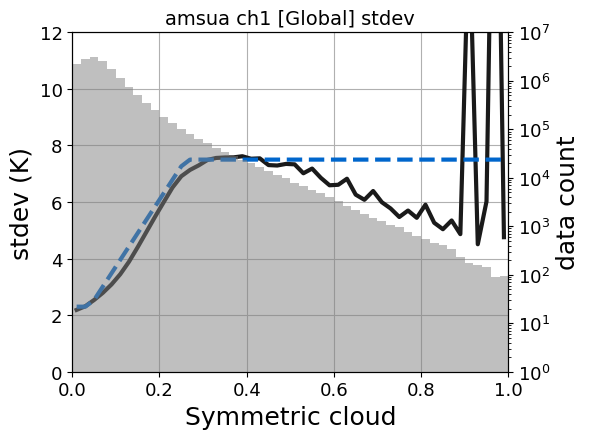

In [17]:
# plot the stdev errors/data counts

save_fig = True
# not decided yet:
#fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/old_ctrl/{instrument}/allsky_stdev_table/'
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/demo_use/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
    
for lat in lats:
    fig, ax1 = plt.subplots(figsize=(6,4.5))
    
    ax1.plot(clddic[lat]['cloud_bin'], clddic[lat]['stdev'], color=(0.1, 0.1, 0.1), linewidth=3)
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['default'], color=(0.4, 0.4, 0.4), linestyle='--', linewidth=3, label='default')
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['v0'], color=(0.3, 0.3, 0.3), linestyle='--', label='SHiELD')
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['v1'], color=(0, 102/255, 204/255), linestyle='--', label='SHiELD fit-2')
    ax1.plot(clddic[lat]['cloud_bin'], err_model['v1'], color=(0, 102/255, 204/255), linestyle='--', linewidth=3, label='SHiELD fit')

    #ax1.set_xlabel('Predictor = Symmetric cloud', fontsize=14)
    ax1.set_xlabel('Symmetric cloud', fontsize=18)
    ax1.set_ylabel('stdev (K)', fontsize=18)
    ax1.set_xlim(0,1)
    if instrument == 'amsua':
        if channel == ('ch1'):
            ax1.set_ylim(0,12)
    #ax1.set_ylim(0,8)
    ax1.grid(True)
    ax1.tick_params(axis='both', labelsize=13)

    ax2 = ax1.twinx()
    ax2.bar(clddic[lat]['cloud_bin'], clddic[lat]['count'], width=0.02, color=(0.5, 0.5, 0.5), alpha=0.5)
    ax2.set_yscale('log')
    ax2.set_ylim(1,1e7)
    ax2.set_ylabel('data count', fontsize=18)
    #ax1.legend()
    ax2.tick_params(axis='both', labelsize=13)

    ax1.set_title(f'{instrument} {channel} [{lat}] stdev', fontsize=14)
    plt.tight_layout()

    if save_fig:
        plt.savefig(f'{fig_dir}/allsky_error_table_{instrument}_{channel}_{lat}_no_default_reference.png', dpi=200, bbox_inches='tight')
        #plt.savefig(f'{fig_dir}/allsky_error_table_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')